<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#In-This-Notebook" data-toc-modified-id="In-This-Notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>In This Notebook</a></span></li><li><span><a href="#Previous-nb's-code-(single-labeled-bbox)" data-toc-modified-id="Previous-nb's-code-(single-labeled-bbox)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Previous nb's code (single labeled bbox)</a></span></li><li><span><a href="#New-Code" data-toc-modified-id="New-Code-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>New Code</a></span><ul class="toc-item"><li><span><a href="#ETL-–-Persons-&amp;-Barn" data-toc-modified-id="ETL-–-Persons-&amp;-Barn-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ETL – Persons &amp; Barn</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Load Data</a></span></li></ul></li></ul></div>

# In This Notebook

**Context**

This notebook will take the single labeled bbox code and attempt multiple bounding boxes. I'll start with doing it just for one class (persons), then for persons and barn animals.

**Log**

- 2020-10-20 (Tuesday): Created nb. Created pickle for persons and barn animals.

# Previous nb's code (single labeled bbox)

lr_min: 0.002754228748381138


epoch,train_loss,valid_loss,mse,cel,acc,time
0,4.428718,1.910814,0.327370,0.273964,0.921206,00:13
1,2.472321,0.891280,0.108744,0.347560,0.883268,00:13
2,1.259003,0.817142,0.089122,0.371532,0.892996,00:13
3,0.772788,0.619469,0.066839,0.285272,0.917315,00:13
4,0.577619,0.717790,0.058796,0.423811,0.866732,00:13
5,0.458959,0.731360,0.055761,0.452553,0.883268,00:14
6,0.333283,0.455273,0.042273,0.243909,0.928988,00:14
7,0.229723,0.398860,0.034902,0.224351,0.935798,00:14
8,0.173786,0.330309,0.032314,0.168739,0.956226,00:14
9,0.153074,0.329883,0.031604,0.171862,0.955253,00:14


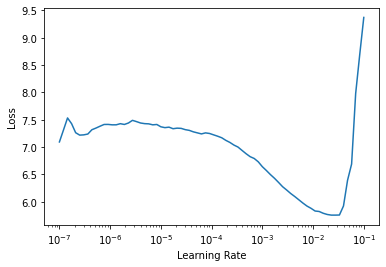

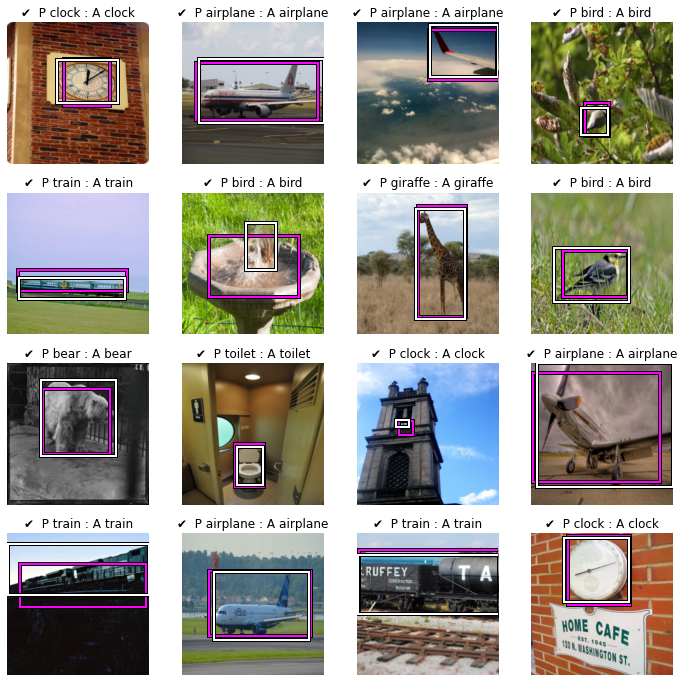

In [ ]:
from fastai.vision.all import *


### Params ###
im_size      = 224
batch_size   = 64
path         = Path('/home/rory/data/coco2017')
valid_split  = .15


### Load data (singles) ###
# Grab cols
def grab_cols(df, cols):
    """Expects: DataFrame df; str or list of strs cols. Returns: L or an LoL."""
    def _grab_col(df, col):
        return L((ColReader(col)(df)).to_list())
    
    if isinstance(cols, str): return _grab_col(df, cols)
    if len(cols)==1: return _grab_col(df, cols)
    if len(cols)>=2:
        r=L()
        for c in cols:
            r.append(_grab_col(df,c))
        return r
df = pd.read_pickle(path/'singles.pkl')
imp, lbl, bbox = grab_cols(df, ['im','lbl','bbox'])
bbox = bbox.map(lambda x:list(x)) # fixed pickle bug; lists incorrectly unpickled as tups
# Create getters for pipeline
imp2lbl  = {p:l for p,l in zip(imp,lbl)}
imp2bbox = {p:b for p,b in zip(imp,bbox)}
def get_lbl(p):  return imp2lbl[p]
def get_bbox(p): return imp2bbox[p]


### Datasets ###
dss_tfms = [[PILImage.create],
            [get_bbox, TensorBBox.create],
            [get_lbl, Categorize()]]
splits = RandomSplitter(valid_split)(imp)
dss = Datasets(imp, tfms=dss_tfms, splits=splits)


### DataLoaders ###
cpu_tfms = [BBoxLabeler(), PointScaler(), Resize(im_size, method='squish'), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
dls = dss.dataloaders(bs=batch_size,after_item=cpu_tfms,after_batch=gpu_tfms,drop_last=True)
dls.n_inp = 1


### Model ###
class custom_module(Module):
    
    def __init__(self, body, head):
        self.body, self.head = body, head

    def forward(self, x):
        return self.head(self.body(x))
body = create_body(resnet34, pretrained=True)
head = create_head(1024, 4+dss.c, ps=0.5)
mod  = custom_module(body, head)


### Loss ###
def mse(f, bb, lbl): return MSELossFlat()(f[:,:4], torch.squeeze(bb))
def cel(f, bb, lbl): return CrossEntropyLossFlat()(f[:,4:], lbl)
def lbb_loss(f, bb, lbl): return 5*mse(f,bb,lbl) + cel(f,bb,lbl)
def acc(f, bb, lbl): return accuracy(f[:,4:], lbl)


### Training ###
learner = Learner(dls, mod, loss_func=lbb_loss, metrics=[mse, cel, acc])
lr_min, _ = learner.lr_find(); print("lr_min:", lr_min)
learner.fit_one_cycle(10, lr=lr_min)


### Results ###
def view_results(learner, n=16, nrows=4, ncols=4, offset=0):
    # get batch of ims & targs, get preds
    ims, targ_bbs, targ_lbls = learner.dls.one_batch()
    preds = learner.model(ims)
    pred_bbs, pred_lbls = preds[:,:4], preds[:,4:].argmax(dim=-1)
    decoded_ims = Pipeline(gpu_tfms).decode(ims)
    
    # show grid results
    for i,ctx in enumerate(get_grid(n, nrows, ncols)):
        idx = i+offset*n
        # title
        pred_cls = dls.vocab[pred_lbls[idx].item()]
        targ_cls = dls.vocab[targ_lbls[idx].item()]
        icon = '✔️' if pred_cls==targ_cls else '✖️'
        title = f"{icon}  P {pred_cls} : A {targ_cls}"
        # im
        show_image(decoded_ims[idx], ctx=ctx, title=title)
        # bbs
        pred_bb = TensorBBox(pred_bbs[idx])
        targ_bb = TensorBBox(targ_bbs[idx])
        ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
        ((targ_bb+1)*224//2).show(ctx=ctx);
view_results(learner)

# New Code

## ETL – Persons & Barn

In [ ]:
# from fastai.vision.all import *

# ### 40sec ###


# ### Get files and annos ###
# # paths to data
# path = Path('/home/rory/data/coco2017')
# train_im_dir, valid_im_dir = 'train2017', 'val2017'
# train_json = 'annotations/instances_train2017.json'
# valid_json = 'annotations/instances_val2017.json'
# # create lists of items
# def get_annos(path, anno_file, im_folder):
#     xs, ys = get_annotations(path/anno_file)
#     return L(xs).map(lambda x: path/im_folder/x), ys
# train_files, train_annos = get_annos(path, train_json, train_im_dir)
# valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
# files  = train_files + valid_files
# annos  = train_annos + valid_annos
# bboxes = [a[0] for a in annos]
# lbls   = [a[1] for a in annos]
# # create helper cols
# is_valid = [0]*len(train_files) + [1]*len(valid_files)
# n_items  = L(len(l) for l in lbls)


# ### Create subsets for task ###
# # sort annos
# def transpose(anno): return list(zip(*anno)) # tensor.t()
# def bbox_area(transposed_anno):
#     b = transposed_anno[0]
#     return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
# def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
# sorted_annos  = L(sort_annos(i) for i in annos)
# sorted_bboxes = L(L(o[0] for o in a) for a in sorted_annos)
# sorted_lbls   = L(L(o[1] for o in a) for a in sorted_annos)

# # create new annos – only include subset of labels
# barn_subset = ['person','cat','dog','cow','sheep','horse']
# barn_idxs   = L(L(o in barn_subset for o in lbl) for lbl in sorted_lbls)
# barn_lbls   = L(o[i] for o,i in zip(sorted_lbls,  barn_idxs))
# barn_bboxes = L(o[i] for o,i in zip(sorted_bboxes,barn_idxs))
# n_barn_items = L(len(l) for l in barn_lbls)
# def count_instances(lbl, lol): return L(sum([o==lbl for o in l]) for l in lol)
# n_persons = count_instances('person', sorted_lbls)
# n_cats    = count_instances('cat', sorted_lbls)
# n_dogs    = count_instances('dog', sorted_lbls)
# n_cows    = count_instances('cow', sorted_lbls)
# n_sheep   = count_instances('sheep', sorted_lbls)
# n_horses  = count_instances('horses', sorted_lbls)

# # persons
# person_idxs   = L(L(o=='person' for o in lbl) for lbl in sorted_lbls)
# person_lbls   = L(o[i] for o,i in zip(sorted_lbls,  person_idxs))
# person_bboxes = L(o[i] for o,i in zip(sorted_bboxes,person_idxs))


# ### Store outputs in a pickle ###
# df = pd.DataFrame({
#     "path": files,
#     "lbl":  lbls,
#     "bbox": bboxes,
#     "is_valid": is_valid,
#     "barn_lbls": barn_lbls,
#     "barn_bboxes": barn_bboxes,
#     "person_lbls": person_lbls,
#     "person_bboxes": person_bboxes,
#     "n_items": n_items,
#     "n_barn_items": n_barn_items,
#     "n_persons": n_persons,
#     "n_cats": n_cats,
#     "n_dogs": n_dogs,
#     "n_cows": n_cows,
#     "n_sheep": n_sheep,
#     "n_horses": n_horses
#     })
# df.to_pickle(path/'20201020_coco_multiple_bboxes_df.pkl')

/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1223: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1615: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subarr = np.array(values, dtype=dtype, copy=copy)


## Load Data

In [ ]:
### Load df ###
df = pd.read_pickle(path/'20201020_coco_multiple_bboxes_df.pkl')

,path,lbl,bbox,is_valid,barn_lbls,barn_bboxes,person_lbls,person_bboxes,n_items,n_barn_items,n_persons,n_cats,n_dogs,n_cows,n_sheep,n_horses
0,/home/rory/data/coco2017/train2017/000000391895.jpg,"[motorcycle, person, person, bicycle]","[[359.17, 146.17, 471.62, 359.74], [339.88, 22.16, 493.76, 322.89000000000004], [471.64, 172.82, 507.56, 220.92], [486.01, 183.31, 516.64, 218.29]]",0,"[person, person]","[[339.88, 22.16, 493.76, 322.89000000000004], [471.64, 172.82, 507.56, 220.92]]","[person, person]","[[339.88, 22.16, 493.76, 322.89000000000004], [471.64, 172.82, 507.56, 220.92]]",4,2,2,0,0,0,0,0
1,/home/rory/data/coco2017/train2017/000000522418.jpg,"[person, knife, cake, sink]","[[382.48, 0.0, 639.28, 474.31], [234.06, 406.61, 454.0, 449.28000000000003], [0.0, 316.04, 406.65, 473.53000000000003], [305.45, 172.05, 362.81, 249.35000000000002]]",0,[person],"[[382.48, 0.0, 639.28, 474.31]]",[person],"[[382.48, 0.0, 639.28, 474.31]]",4,1,1,0,0,0,0,0
2,/home/rory/data/coco2017/train2017/000000184613.jpg,"[cow, cow, cow, cow, cow, umbrella, cow, person, person, person, person, person, person, person, person, person, person, person, person, person, cow, cow, cow, person]","[[239.9, 111.16, 368.52, 210.87], [285.08, 85.99, 455.30999999999995, 150.47], [452.49, 85.93, 500.0, 108.75], [296.96, 68.01, 319.34999999999997, 89.07000000000001], [461.07, 75.92, 495.53, 90.11], [103.44, 31.01, 258.23, 166.16], [65.33, 59.84, 85.97, 72.15], [146.48, 65.69, 307.31, 312.59000000000003], [8.29, 57.26, 83.62, 204.16], [45.24, 48.41, 91.21000000000001, 173.95999999999998], [20.71, 44.87, 64.99000000000001, 95.22999999999999], [0.75, 76.59, 36.91, 182.06], [343.28, 63.97, 362.23999999999995, 92.7], [362.05, 66.51, 379.49, 91.29], [382.76, 60.79, 395.58, 93.33], [413.61, 61.0...",0,"[person, cow, person, cow, person, cow, person, person, person, cow, cow, cow, person, cow, cow, person, person, person, person, person, cow, person, person]","[[0, 35, 481, 185], [255.71, 132.65, 493.09000000000003, 317.67], [146.48, 65.69, 307.31, 312.59000000000003], [239.9, 111.16, 368.52, 210.87], [8.29, 57.26, 83.62, 204.16], [285.08, 85.99, 455.30999999999995, 150.47], [45.24, 48.41, 91.21000000000001, 173.95999999999998], [0.75, 76.59, 36.91, 182.06], [20.71, 44.87, 64.99000000000001, 95.22999999999999], [271.13, 87.59, 349.22, 110.60000000000001], [452.49, 85.93, 500.0, 108.75], [257.75, 80.2, 287.42, 110.87], [343.28, 63.97, 362.23999999999995, 92.7], [461.07, 75.92, 495.53, 90.11], [296.96, 68.01, 319.34999999999997, 89.07000000000001]...","[person, person, person, person, person, person, person, person, person, person, person, person, person, person]","[[0, 35, 481, 185], [146.48, 65.69, 307.31, 312.59000000000003], [8.29, 57.26, 83.62, 204.16], [45.24, 48.41, 91.21000000000001, 173.95999999999998], [0.75, 76.59, 36.91, 182.06], [20.71, 44.87, 64.99000000000001, 95.22999999999999], [343.28, 63.97, 362.23999999999995, 92.7], [314.34, 57.09, 328.03, 88.82000000000001], [362.05, 66.51, 379.49, 91.29], [382.76, 60.79, 395.58, 93.33], [413.61, 61.01, 425.53000000000003, 88.21], [288.04, 57.1, 297.8, 86.81], [272.72, 56.58, 279.09000000000003, 87.12], [8.93, 48.6, 18.1, 59.29]]",24,23,14,0,0,9,0,0
3,/home/rory/data/coco2017/train2017/000000318219.jpg,"[person, person, mouse, mouse, keyboard, keyboard, mouse, tv, tv, tv, mouse]","[[40.65, 38.8, 459.03, 640.0], [0.0, 0.0, 198.92, 631.35], [455.98, 436.73, 514.5500000000001, 473.09000000000003], [405.44, 594.41, 482.03, 634.64], [314.26, 479.43, 470.66999999999996, 569.83], [276.83, 241.89, 436.2, 406.9], [329.2, 192.18, 397.09, 240.20000000000002], [505.24, 0.0, 553.1, 309.25], [470.68, 0.0, 516.61, 191.86], [442.51, 0.0, 485.9, 119.87], [289.7, 319.6, 382.2, 340.67]]",0,"[person, person]","[[40.65, 38.8, 459.03, 640.0], [0.0, 0.0, 198.92, 631.35]]","[person, person]","[[40.65, 38.8, 459.03, 640.0], [0.0, 0.0, 198.92, 631.35]]",11,2,2,0,0,0,0,0
4,/home/rory/data/coco2017/train2017/000000554625.jpg,"[tv, tv, person, pe